In [58]:
# Day 3 Wrap Bivariate Analysis and KPIs
# 3.1 Import Libraries.

    # Manipulating Data
import pandas as pd
import numpy as np

    # Visualizing Data
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter
from matplotlib_venn import venn2

    # Statistical Analysis
from scipy.stats import (
    ttest_ind,
    chi2_contingency,
    norm,
    mannwhitneyu,
    shapiro,
    probplot
)
from statsmodels.stats.proportion import (
    proportions_ztest,
    proportions_chisquare
)
import statsmodels.api as sm

import sys
sys.path.append("../src")

pd.set_option('display.float_format', '{:.2f}'.format)
    # Load Clean Data
df_full = pd.read_pickle('../data/clean_data_txt/df_full.pkl')
df_full.head(3)

,client_id,visitor_id,visit_id,process_step,date_time,variation,client_tenure_years,client_tenure_months,age,gender,number_of_accounts,balance,calls_6_months,logons_6_months
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5,64,79.00,U,2,189023.86,1,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5,64,79.00,U,2,189023.86,1,4
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5,64,79.00,U,2,189023.86,1,4


In [59]:
# We need to create correlation matrix and then plot it using heatmap. So gender have to be map as numerical as test and control.
    # Convert categorical variables to numerical
df_full["gender_num"], gender_mapping = pd.factorize(df_full["gender"])
df_full["variation_num"], variation_mapping = pd.factorize(df_full["variation"])
print("Gender Mapping:")
for num, category in enumerate(gender_mapping):
    print(f"{category} → {num}")
print("\nVariation Mapping:")
for num, category in enumerate(variation_mapping):
    print(f"{category} → {num}")

Gender Mapping:
U → 0
M → 1
F → 2

Variation Mapping:
Test → 0
Control → 1


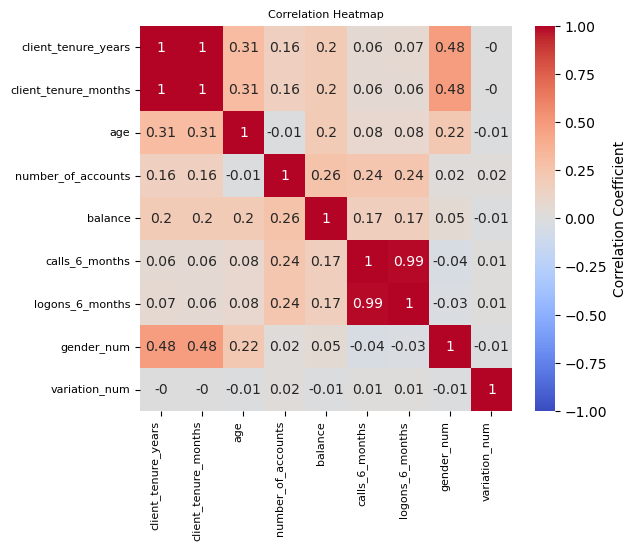

In [60]:
# Lets create a correlation matrix
    # Drop non-numeric and redundant columns
df_numeric = df_full.drop(columns=["client_id", "gender", "variation", "visitor_id", "visit_id", "date_time", "process_step"])
    # Correlation matrix
correlation_matrix = df_numeric.corr()
    # Create the heatmap 
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(round(correlation_matrix, 2), annot=True, ax=ax,
            cmap="coolwarm", vmin=-1, vmax=1,
            cbar_kws={"label": "Correlation Coefficient"}) 
    #  Labels and title
plt.title("Correlation Heatmap", fontsize=8)
plt.xticks(ha="right", fontsize=8)  
plt.yticks(fontsize=8)
plt.show()

# Correlation Insights

## Strong Correlations
- **client_tenure_years ↔ client_tenure_months**: `+1.00`
  - Perfect correlation (as expected, months = years × 12)
  - Redundant for modeling — we'll keep one

- **logons_6_months ↔ calls_6_months**: `+0.99`
  - Clients with higher numbers of logins tend to call more
  - Maybe the two (2) of them can be redundant, keep one

## Moderate Correlations
- **client_tenure_years ↔ gender_num**: `0.48`
  - Gender appears linked to tenure — possible demographic skew also have 0.22 with age, weak and not strong for conclusions. 
  - Consider stratified sampling or fairness checks
  
- **client_tenure_years ↔ age**: `0.31`
  - Client tenure in years and age are moderate positive correlation.
  - Expected

## Weak or No Correlations
- **age, number_of_accounts, logons_6_months**: mostly weak correlations
  - These variables behave independently
  - Useful for segmentation or clustering
- **variation**: is virtually zero, so the assigment to client confirms more to be random! very good for A/B testing.

In [61]:
# Use at least completion rate, time spent on each step and error rates. Add any KPIs you might find relevant.
# Evaluated how the new design's performance compare to the old one, given the chosen KPIs (completion rate, time spent on each step and error rates).
    # The completion rate: indicates the number of visits which reach the final 'confirm' step.
    # Time Spent on Each Step: The average duration users spend on each step.
    # Error Rates: If there’s a step where users go back to a previous step or repeat it
df_full.info()
df_full.client_id.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317235 entries, 0 to 317234
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   client_id             317235 non-null  object        
 1   visitor_id            317235 non-null  object        
 2   visit_id              317235 non-null  object        
 3   process_step          317235 non-null  object        
 4   date_time             317235 non-null  datetime64[ns]
 5   variation             317235 non-null  object        
 6   client_tenure_years   317235 non-null  int64         
 7   client_tenure_months  317235 non-null  int64         
 8   age                   317235 non-null  float64       
 9   gender                317235 non-null  object        
 10  number_of_accounts    317235 non-null  int64         
 11  balance               317235 non-null  float64       
 12  calls_6_months        317235 non-null  int64         
 13 

50500

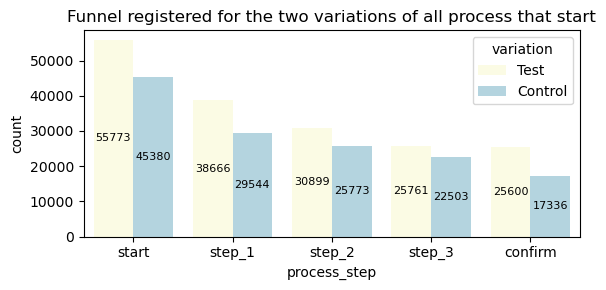

In [62]:
# Completion Rate, create a boolean True/False if the string "confirm" is found or not in the process_step values. 

    # for test CRtest = (completition of group test) / (total visits group test)
    # for control CRctrl = (completition of group control) / (total visits group control)

    # If not all confirms are register as start-1-2-3-confirm, we need those valid visits that reach completition so later:

    # for test CRtest = (valid visits that reach completition of group test) / (total visits group test)
    # for test CRctrl = (valid visits that reach completition of group control) / (total visits group control) 

# Define funnel
funnel = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Barchars
fig, ax = plt.subplots(figsize=(6, 3))
sns.countplot(
    x='process_step',
    data=df_full,
    order = funnel,
    hue='variation',
    palette=['lightyellow', 'lightblue'] 
)
for container in ax.containers:
    ax.bar_label(container, color='black', fmt='%d', label_type='center', fontsize=8)

plt.title('Funnel registered for the two variations of all process that start')
plt.tight_layout()
plt.show()

In [63]:
# How many times is visiting each client for test and control?
df_visits = df_full.groupby(['client_id', 'variation']).agg(
    total_visits=('visit_id', 'count')
).reset_index() 
df_visits.head()

,client_id,variation,total_visits
0,1000062,Control,5
1,1000353,Control,7
2,1000536,Control,7
3,1000672,Control,5
4,1001101,Test,14


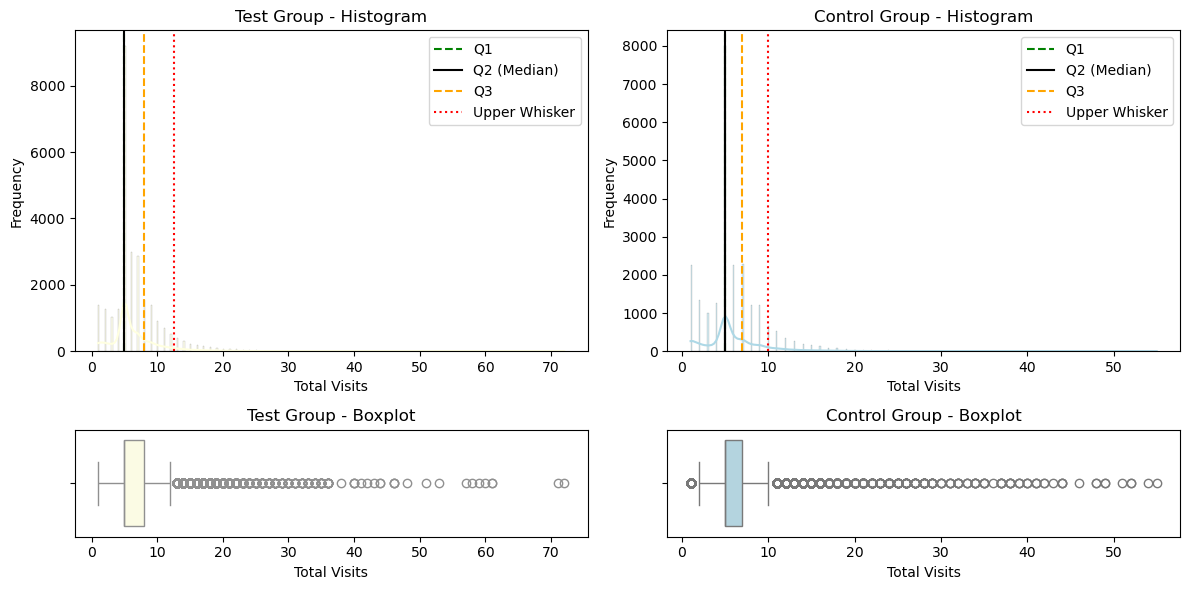

In [64]:
# Boxplot and Histogram 

    # Set up the figure
fig, axes = plt.subplots(2, 2, figsize=(12, 6), gridspec_kw={'height_ratios': [3, 1]})

    # Loop through each variation
for i, variation in enumerate(['Test', 'Control']):
    data = df_visits[df_visits['variation'] == variation]['total_visits'].dropna()

    # Compute quartiles and whisker
    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    upper_whisker = q3 + 1.5 * iqr

    # Histogram
    sns.histplot(data, bins='auto', kde=True, ax=axes[0, i],
                 color='lightyellow' if variation == 'Test' else 'lightblue')
    axes[0, i].axvline(q1, color='green', linestyle='--', label='Q1')
    axes[0, i].axvline(q2, color='black', linestyle='-', label='Q2 (Median)')
    axes[0, i].axvline(q3, color='orange', linestyle='--', label='Q3')
    axes[0, i].axvline(upper_whisker, color='red', linestyle=':', label='Upper Whisker')
    axes[0, i].set_title(f'{variation} Group - Histogram')
    axes[0, i].set_xlabel('Total Visits')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].legend()

    # Boxplot
    sns.boxplot(x=data, ax=axes[1, i],
                color='lightyellow' if variation == 'Test' else 'lightblue')
    axes[1, i].set_title(f'{variation} Group - Boxplot')
    axes[1, i].set_xlabel('Total Visits')

plt.tight_layout()
plt.show()

## Bias
### If i let a person test something, ideally the first session for each test or control should be unbias, same chance for everyone, but we see people visits x ~ 5 times butand some clients that do 50 times? the explanaitons are wide and RANDOM (i just left the website open and reload every time i did funnel, i was in step 2 and decide go for an arepa or sandwich, i was about to confirm and i dont see the new button)

### In statistics our means and variations are sensitive to outliers. We use last visit of those 50 times and for analysis we reduce the bias limitating visit to upper whisker so the oultiers dont affect severely the result.
## Instructions say: If a client start several times and hit confirmation several times, only the LAST!!! should be used. 

In [65]:
# Clients that visits excede the upper whisker
# Calculate Q1 and Q3
Q1 = df_visits['total_visits'].quantile(0.25)
Q3 = df_visits['total_visits'].quantile(0.75)

# Compute IQR and upper whisker
IQR = Q3 - Q1
upper_whisker = Q3 + 1.5 * IQR

# Find clients exceeding the upper whisker
outliers_visits_clients = df_visits[
    df_visits['total_visits'] > upper_whisker
]['client_id']
# check the number of cients that exceed the upper whisker
print(f"There are {len(outliers_visits_clients)} clients that exceed the upper whisker.")

There are 5162 clients that exceed the upper whisker.


In [ ]:
# Aplly this filter to the df_full dropping the outliers
df_full = df_full[~df_full['client_id'].isin(outliers_visits_clients)]
# Add total_visits column
df_full['total_visits'] = df_full.groupby('client_id')['visit_id'].transform('count')
# Drop client_tenure_months
df_full = df_full.drop(columns=['client_tenure_months'])
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239704 entries, 8 to 317234
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_id            239704 non-null  object        
 1   visitor_id           239704 non-null  object        
 2   visit_id             239704 non-null  object        
 3   process_step         239704 non-null  object        
 4   date_time            239704 non-null  datetime64[ns]
 5   variation            239704 non-null  object        
 6   client_tenure_years  239704 non-null  int64         
 7   age                  239704 non-null  float64       
 8   gender               239704 non-null  object        
 9   number_of_accounts   239704 non-null  int64         
 10  balance              239704 non-null  float64       
 11  calls_6_months       239704 non-null  int64         
 12  logons_6_months      239704 non-null  int64         
 13  gender_num         

In [69]:
df_full.describe()

,date_time,client_tenure_years,age,number_of_accounts,balance,calls_6_months,logons_6_months,gender_num,variation_num,total_visits
count,239704,239704.00,239704.00,239704.00,239704.00,239704.00,239704.00,239704.00,239704.00,239704.00
mean,2017-04-19 13:37:31.916342784,11.97,46.95,2.26,148935.72,3.09,6.13,0.97,0.46,6.21
min,2017-03-15 00:19:28,2.00,17.00,1.00,23789.44,0.00,3.00,0.00,0.00,1.00
25%,2017-04-03 22:25:10.249999872,6.00,33.50,2.00,39706.43,1.00,4.00,0.00,0.00,5.00
50%,2017-04-12 11:45:55,11.00,47.50,2.00,65244.90,3.00,6.00,1.00,0.00,6.00
75%,2017-04-27 09:00:05.249999872,15.00,59.50,2.00,138839.51,5.00,8.00,2.00,1.00,8.00
max,2017-06-20 23:26:00,55.00,96.00,7.00,8986419.77,6.00,9.00,2.00,1.00,10.00
std,NaN,6.84,15.39,0.54,293445.50,2.18,2.17,0.82,0.50,1.97


In [ ]:
# Visits calculation Flag
    # Visits that have 'confirm' registered as one of their steps
confirm_visits = df_full[df_full['process_step'] == 'confirm']['visit_id'].unique()
    # So assign them a 'confirm' value if True, or no_confirm if it isn't
df_full['confirm_check'] = df_full['visit_id'].isin(confirm_visits).map({True: 'True', False: 'False'})
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 239704 entries, 8 to 317234
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   client_id            239704 non-null  object        
 1   visitor_id           239704 non-null  object        
 2   visit_id             239704 non-null  object        
 3   process_step         239704 non-null  object        
 4   date_time            239704 non-null  datetime64[ns]
 5   variation            239704 non-null  object        
 6   client_tenure_years  239704 non-null  int64         
 7   age                  239704 non-null  float64       
 8   gender               239704 non-null  object        
 9   number_of_accounts   239704 non-null  int64         
 10  balance              239704 non-null  float64       
 11  calls_6_months       239704 non-null  int64         
 12  logons_6_months      239704 non-null  int64         
 13  gender_num         

In [73]:
 # Total unique visits for both variations
total_visits = df_full.groupby('variation')['visit_id'].nunique()

    # Totals per variation
n_test_total = df_full.groupby('variation')['visit_id'].nunique()['Test']
n_control_total = df_full.groupby('variation')['visit_id'].nunique()['Control']

    # Confirmed visits for each variation
confirmed_visits = df_full[df_full['confirm_check'] == 'True'].groupby('variation')['visit_id']

    # Total visits with no_cofirm per variation
n_test_nonvalidated = confirmed_visits.nunique()['Test']
n_control_nonvalidated = confirmed_visits.nunique()['Control']

    # Proportions
p_test_nonvalidated = n_test_nonvalidated / n_test_total
p_control_nonvalidated = n_control_nonvalidated / n_control_total

    # Results
print(f"Of total {n_test_total} test visits, {n_test_nonvalidated} reached the 'confirm' step.")
print(f"Of total {n_control_total} control visits, {n_control_nonvalidated} reached the 'confirm' step.")

Of total 29579 test visits, 18327 reached the 'confirm' step.
Of total 26584 control visits, 14208 reached the 'confirm' step.


In [ ]:
# Valid visits calculation

# Define required funnel steps
funnel_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
required_steps = set(funnel_steps)

# Total visits per variation
total_visits = df_full.groupby('variation')['visit_id'].nunique()
n_test_total = total_visits.get('Test', 0)
n_control_total = total_visits.get('Control', 0)

# Group visit_id by steps completed
visit_steps = df_full.groupby('visit_id')['process_step'].apply(set)

# Filter visits that completed all funnel steps
valid_visit_ids = visit_steps[visit_steps.apply(lambda steps: required_steps.issubset(steps))].index

# Get variation for each valid visit
valid_variations = df_full[df_full['visit_id'].isin(valid_visit_ids)][['visit_id', 'variation']].drop_duplicates()

# Count valid visits per variation
valid_counts = valid_variations['variation'].value_counts()
n_test_valid = valid_counts.get('Test', 0)
n_control_valid = valid_counts.get('Control', 0)

# Proportions
p_test_valid = n_test_valid / n_test_total if n_test_total > 0 else 0
p_control_valid = n_control_valid / n_control_total if n_control_total > 0 else 0

# Results
print("KPI === COMPLETITION RATE")
print(f"Of total {n_test_total} test visits, {n_test_valid} valid visits completed the full funnel ({p_test_valid}).")
print(f"Of total {n_control_total} control visits, {n_control_valid} valid visits completed the full funnel ({p_control_valid}).")
print(f"The lift is {p_test_valid - p_control_valid}. to be tested with hypothesis test" )
# Barchar completition rate per steps (to do)

KPI === COMPLETITION RATE
Of total 29579 test visits, 15551 valid visits completed the full funnel (0.5257446161127827).
Of total 26584 control visits, 13283 valid visits completed the full funnel (0.49966145049653926).
The lift is 0.02608316561624341. to be tested with hypothesis test


In [88]:
# KPI Time spent in each step for each variation for each visit

# Ensure timestamps are in datetime format
df_full['timestamp'] = pd.to_datetime(df_full['date_time'])

# Sort by visit and timestamp
df_sorted = df_full.sort_values(['visit_id', 'date_time'])

# Compute time difference between steps
df_sorted['step_duration'] = df_sorted.groupby('visit_id')['date_time'].diff()

# Drop rows where duration is NaT (first step per visit)
df_step_times = df_sorted.dropna(subset=['step_duration'])

# Aggregate: average time per step per variation
kpi_step_time = df_step_times.groupby(['variation', 'visit_id', 'process_step'])['step_duration'].mean().reset_index()

# Optional: convert to seconds
kpi_step_time['step_duration_seconds'] = kpi_step_time['step_duration'].dt.total_seconds()

# Preview
kpi_step_time.head()

,variation,visit_id,process_step,step_duration,step_duration_seconds
0,Control,100037962_47432393712_705583,start,0 days 00:00:46.500000,46.50
1,Control,100037962_47432393712_705583,step_1,0 days 00:00:39,39.00
2,Control,100057941_88477660212_944512,step_1,0 days 00:00:28.500000,28.50
3,Control,100057941_88477660212_944512,step_2,0 days 00:00:53.500000,53.50
4,Control,100057941_88477660212_944512,step_3,0 days 00:00:45,45.00


In [89]:
kpi_step_time.describe()

,step_duration,step_duration_seconds
count,156628,156628.00
mean,0 days 00:01:15.618011904,75.62
std,0 days 00:02:22.998836200,143.00
min,0 days 00:00:00,0.00
25%,0 days 00:00:16,16.00
50%,0 days 00:00:39,39.00
75%,0 days 00:01:22,82.00
max,0 days 03:36:20,12980.00


In [ ]:
# Ensure timestamp is datetime
df = df_full.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Sort by visit and timestamp
df = df.sort_values(['visit_id', 'timestamp'])

# Get next step and next timestamp per visit
df['next_step'] = df.groupby('visit_id')['process_step'].shift(-1)
df['next_time'] = df.groupby('visit_id')['timestamp'].shift(-1)

# Duration spent on current step = time until next step, for rows that have a next_time
df.loc[:, 'step_duration'] = df['next_time'] - df['timestamp']

# Enforce convention: confirm has zero duration (terminal step)
df.loc[df['process_step'] == 'confirm', 'step_duration'] = pd.Timedelta(seconds=0)

# Keep only rows where step_duration is not null (we want steps with a defined duration or explicit zero)
df_step_times = df[df['step_duration'].notna()].copy()

# Convert to seconds using .loc to avoid SettingWithCopyWarning
df_step_times.loc[:, 'step_duration_seconds'] = df_step_times['step_duration'].dt.total_seconds()

# Optional: ensure consistent step order
step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Pivot: mean duration per step per variation
pivot_step_time = (
    df_step_times
    .groupby(['process_step', 'variation'])['step_duration_seconds']
    .mean()
    .unstack(fill_value=0)
    .reindex(step_order)  # will put rows in desired order; missing rows become NaN
    .round(2)
)

# Replace NaN with 0 for steps that may be missing
pivot_step_time = pivot_step_time.fillna(0)

print(pivot_step_time)

variation     Control   Test
process_step                
start           57.46  51.39
step_1          46.56  56.53
step_2          94.35  92.32
step_3         129.58 111.67
confirm          0.00   0.00


## KPI mean time per steps
 
### The user take more time in test for start to complete step_1 (cause is something new)

### The test take less in steps 2 and 3

In [ ]:
# KPI Error Rates: If there’s a step where users go back to a previous step or repeat it

# Define the canonical process step order (adjust names to match your data)
process_step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Work directly on df_full and ensure datetime
df_full = df_full.copy()
df_full['date_time'] = pd.to_datetime(df_full['date_time'])

# Map process steps to numeric order
step_map = {step: i for i, step in enumerate(process_step_order)}
df_full.loc[:, 'process_step_order'] = df_full['process_step'].map(step_map)

# Sort by visit_id and date_time for correct order of events
df_full = df_full.sort_values(['visit_id', 'date_time'])

# Compute previous step and previous step order within each visit
df_full.loc[:, 'prev_step'] = df_full.groupby('visit_id')['process_step'].shift(1)
df_full.loc[:, 'prev_step_order'] = df_full.groupby('visit_id')['process_step_order'].shift(1)

# Flag: same step repeated consecutively within the same visit
df_full.loc[:, 'step_repeat_error'] = (
    (df_full['process_step'] == df_full['prev_step']) &
    (df_full['visit_id'] == df_full['visit_id'].shift(1))
).astype(int)

# Flag: user moved back to an earlier step (previous step order > current step order)
df_full.loc[:, 'step_back_error'] = (
    (df_full['prev_step_order'].notna()) &
    (df_full['prev_step_order'] > df_full['process_step_order']) &
    (df_full['visit_id'] == df_full['visit_id'].shift(1))
).astype(int)

# Aggregate errors per visit_id and process_step (keep variation for grouping)
error_df = (
    df_full
    .groupby(['visit_id', 'process_step'], as_index=False)
    .agg(
        variation=('variation', 'first'),
        step_repeat_errors=('step_repeat_error', 'sum'),
        step_back_errors=('step_back_error', 'sum')
    )
)

# Aggregate total errors per variation
error_summary = (
    error_df
    .groupby('variation', as_index=False)
    .agg(
        total_step_back_errors=('step_back_errors', 'sum'),
        total_step_repeat_errors=('step_repeat_errors', 'sum')        
    )
)
print(error_summary) 

  variation  total_step_back_errors  total_step_repeat_errors
0   Control                    5521                      7298
1      Test                    8138                     11139


## KPI Errors

### Have to be done per steps, but in general test gives more errors than control.